In [1]:
try:
    import SimpleITK as sitk

    import k3d
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from IPython.display import HTML, display

    import os
    import numpy as np
    import pandas as pd
    
    import etl
    
except ImportError:
    !python3 -m pip install numpy itk vtk torch SimpleITK gsutil k3d tqdm -q --no-warn-script-location
    ## MUST RUN THESE TO ENABLE K3D VISUALIZATION!
    !jupyter nbextension install --user --py k3d
    !jupyter nbextension enable k3d --user --py
    
    print("Restart kernel!")
    import IPython
    IPython.Application.instance().kernel.do_shutdown(True)

### Copy images and masks from GCS bucket to local directory structure

In [2]:
# LOCAL DIRECTORY TREE STRUCTURE

#########################
# \_ la-seg             #  <- GCS Bucket
#     \_ hi-res         #  <- Fetched from GCS
#         |_ masks      #
#           \ ...       #
#         \_ images     #
#           \ ...       #
#     \_ lo-res         #  -> Uploaded to GCS
#         |_ masks64    #
#           \ ...       #
#         \_ images64   #
#           \ ...       #
#########################

### DEFINE PATHS
data_path = './la-seg/'                                     # GLOBALVAR

hi_res_path = os.path.join(data_path, 'hi-res')             # GLOBALVAR
hi_res_images_path = os.path.join(hi_res_path, 'images')    # GLOBALVAR
hi_res_masks_path = os.path.join(hi_res_path, 'masks')      # GLOBALVAR

lo_res_path = os.path.join(data_path, 'lo-res')             # GLOBALVAR
lo_res_images_path = os.path.join(lo_res_path, 'images64')  # GLOBALVAR
lo_res_masks_path = os.path.join(lo_res_path, 'masks64')    # GLOBALVAR

etl.safe_mkdir([data_path,
                hi_res_path, hi_res_images_path, hi_res_masks_path,
                lo_res_path, lo_res_images_path, lo_res_masks_path])

In [3]:
# PREREQUISITE NOTES:
# 1. IF YOU DO NOT HAVE THE GCLOUD SDK INSTALLED, INSTALL IT NOW
# 2. IF GCLOUD IS NOT YET AUTHENTICATED TO YOUR GOOGLE ACCOUNT,
# RUN THIS COMMAND IN A TERMINAL ENVIRONMENT TO AUTHENTICATE:
# !gcloud auth login --activate --launch-browser

project_id = 'medicalimagerepresentation01'
!gcloud config set project {project_id}

# UNCOMMENT THESE LINES TO FETCH DATA FROM GCS; LEAVE COMMENTED IF
# ALREADY FETCHED ONCE. IF FETCHING, BE SURE TO RUN
# remove_undersized_images() BELOW
# !gsutil -m cp -r gs://la-seg/hi-res/masks/*.gz {hi_res_masks_path}
# !gsutil -m cp -r gs://la-seg/hi-res/images/*.gz {hi_res_images_path}

# REMOVE IMAGES WITH DEPTH < 125 mm:
# ./la-seg/hi-res/images/MAIN-751.nii.gz and ./la-seg/hi-res/masks/SEG-751.nii.gz
# ./la-seg/hi-res/images/MAIN-752.nii.gz and ./la-seg/hi-res/masks/SEG-752.nii.gz

# def remove_undersized_images(min_millimeters=(0, 0, 125)):
#     img_files = sorted(os.listdir(hi_res_images_path))
#     msk_files = sorted(os.listdir(hi_res_masks_path))
#     for img_name, msk_name in zip(img_files, msk_files):
#         img_path = os.path.join(hi_res_images_path, img_name)
#         msk_path = os.path.join(hi_res_masks_path, msk_name)

#         img = sitk.ReadImage(img_path)
#         msk = sitk.ReadImage(msk_path)

#         img_size_vox = np.array(img.GetSize())
#         msk_size_vox = np.array(msk.GetSize())

#         assert(np.array_equal(img_size_vox, msk_size_vox))

#         img_spacing = np.array(img.GetSpacing())
#         msk_spacing = np.array(img.GetSpacing())

#         assert(np.array_equal(img_spacing, msk_spacing))

#         img_size_mm = img_size_vox * img_spacing
#         msk_size_mm = msk_size_vox * msk_spacing

#         is_undersized = (np.less(img_size_mm, min_millimeters)).any()

#         if is_undersized:
#             print(f'Removing {img_path} and {msk_path}')
#             os.remove(img_path)
#             os.remove(msk_path)

# remove_undersized_images()

Updated property [core/project].


In [4]:
if etl.validate_bucket_download(hi_res_images_path, hi_res_masks_path):
    print('Bucket download passed all tests.')
else:
    raise ValueError('Bucket download did not pass all tests.')

Bucket download passed all tests.


# Resampling

In [5]:
def resample_masks_and_images(validate=True):
    print('Beginning augmentation.')
    
    from time import time
    
    start = time()

    etl.augmentation_pipeline(hi_res_images_path, hi_res_masks_path,
                              lo_res_images_path, lo_res_masks_path,
                              n_jobs=16)
    
    print(f'Finished in {time() - start:.1f} s')

    if validate:
        etl.validate_augmentation(hi_res_images_path, hi_res_masks_path,
                                  lo_res_images_path, lo_res_masks_path)

if resample_masks_and_images(validate=True):
    print('Resampling validation passed all tests.')

Beginning augmentation.
Finished in 42.6 s
Testing data integrity...Passed!
Testing label quantization...Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]
Passed! Quantized to [0, 1]

# Visualizations


In [73]:
mask_names = sorted(os.listdir(lo_res_masks_path))
print('IMG #, NAME')
list(zip(range(len(mask_names)), mask_names))

IMG #, NAME


[(0, 'SEG-1.nii.gz'),
 (1, 'SEG-103.nii.gz'),
 (2, 'SEG-126.nii.gz'),
 (3, 'SEG-129.nii.gz'),
 (4, 'SEG-135.nii.gz'),
 (5, 'SEG-137.nii.gz'),
 (6, 'SEG-142.nii.gz'),
 (7, 'SEG-155.nii.gz'),
 (8, 'SEG-179.nii.gz'),
 (9, 'SEG-198.nii.gz'),
 (10, 'SEG-205.nii.gz'),
 (11, 'SEG-25.nii.gz'),
 (12, 'SEG-253.nii.gz'),
 (13, 'SEG-272.nii.gz'),
 (14, 'SEG-288.nii.gz'),
 (15, 'SEG-314.nii.gz'),
 (16, 'SEG-357.nii.gz'),
 (17, 'SEG-360.nii.gz'),
 (18, 'SEG-38.nii.gz'),
 (19, 'SEG-440.nii.gz'),
 (20, 'SEG-456.nii.gz'),
 (21, 'SEG-459.nii.gz'),
 (22, 'SEG-460.nii.gz'),
 (23, 'SEG-506.nii.gz'),
 (24, 'SEG-524.nii.gz'),
 (25, 'SEG-543.nii.gz'),
 (26, 'SEG-555.nii.gz'),
 (27, 'SEG-586.nii.gz'),
 (28, 'SEG-593-2.nii.gz'),
 (29, 'SEG-593.nii.gz'),
 (30, 'SEG-603.nii.gz'),
 (31, 'SEG-636.nii.gz'),
 (32, 'SEG-643.nii.gz'),
 (33, 'SEG-679.nii.gz'),
 (34, 'SEG-686.nii.gz'),
 (35, 'SEG-693.nii.gz'),
 (36, 'SEG-695.nii.gz'),
 (37, 'SEG-70.nii.gz'),
 (38, 'SEG-708.nii.gz'),
 (39, 'SEG-751.nii.gz'),
 (40, 'SEG-75

In [7]:
aug_msks = etl.get_images(lo_res_masks_path, n = -1)
aug_imgs = etl.get_images(lo_res_images_path, n = -1)

In [22]:
heart_id = 43

## Segmentations
### Lo-res

In [61]:
etl.k3d_plot(aug_msks[heart_id])

Output()

### Hi-res

In [24]:
#etl.k3d_plot(sample_masks_hi_res[heart_id])

## Images
### Lo-res

In [70]:
etl.k3d_plot(aug_imgs[heart_id], color_range=[0, 300])

Output()

### Hi-res

In [12]:
#etl.k3d_plot(sample_images_hi_res[heart_id], color_range=[100, 300]) 

## Cropping Visualization

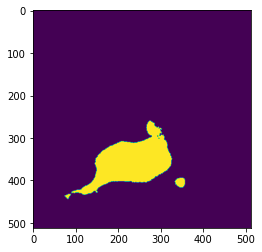

In [94]:
etl.imshow_sitk(image[:,:,96])

In [124]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

im = sitk.ReadImage(os.path.join(hi_res_masks_path, 'SEG-253.nii.gz'))
im = sitk.GetArrayFromImage(image[:,:,96])

x = im.shape[0]
y = im.shape[1]

Text(0.5, 1.0, 'Dynamic Ratio Cropping')

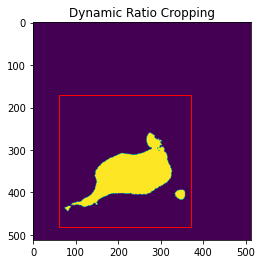

In [129]:
diff_x = 200
diff_y = 200
ratio_x = 0.3
ratio_y = 0.85

plt.imshow(im)

ax = plt.gca()

top_x = int(ratio_x * diff_x)
top_y = int(ratio_y * diff_y)
bot_x = x - top_x - (1 - ratio_x)*diff_x
bot_y = y - top_y - (1 - ratio_y)*diff_y
rect = Rectangle((top_x, top_y), bot_x, bot_y,linewidth=1,edgecolor='r',facecolor='none')

ax.add_patch(rect)
plt.title('Dynamic Ratio Cropping')

Text(0.5, 1.0, 'Fixed Ratio Cropping')

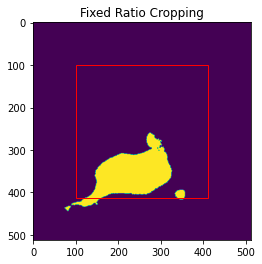

In [126]:
ratio_x = 0.5
ratio_y = 0.5

plt.imshow(im)
ax = plt.gca()


top_x = int(ratio_x * diff_x)
top_y = int(ratio_y * diff_y)
bot_x = x - top_x - (1 - ratio_x)*diff_x
bot_y = y - top_y - (1 - ratio_y)*diff_y
rect = Rectangle((top_x, top_y), bot_x, bot_y,linewidth=1,edgecolor='r',facecolor='none')

ax.add_patch(rect)
plt.title('Fixed Ratio Cropping')